               id             date     price  bedrooms  bathrooms  \
0      7129300520  20141013T000000  221900.0       3.0       1.00   
1      6414100192  20141209T000000  538000.0       3.0       2.25   
2      5631500400  20150225T000000  180000.0       2.0       1.00   
3      2487200875  20141209T000000  604000.0       4.0       3.00   
4      1954400510  20150218T000000  510000.0       3.0       2.00   
...           ...              ...       ...       ...        ...   
21608   263000018  20140521T000000  360000.0       3.0       2.50   
21609  6600060120  20150223T000000  400000.0       4.0       2.50   
21610  1523300141  20140623T000000  402101.0       2.0       0.75   
21611   291310100  20150116T000000  400000.0       3.0       2.50   
21612  1523300157  20141015T000000  325000.0       2.0       0.75   

       sqft_living  sqft_lot  floors  waterfront  view  ...  grade  \
0           1180.0    5650.0     1.0           0     0  ...      7   
1           2570.0    7242.0   

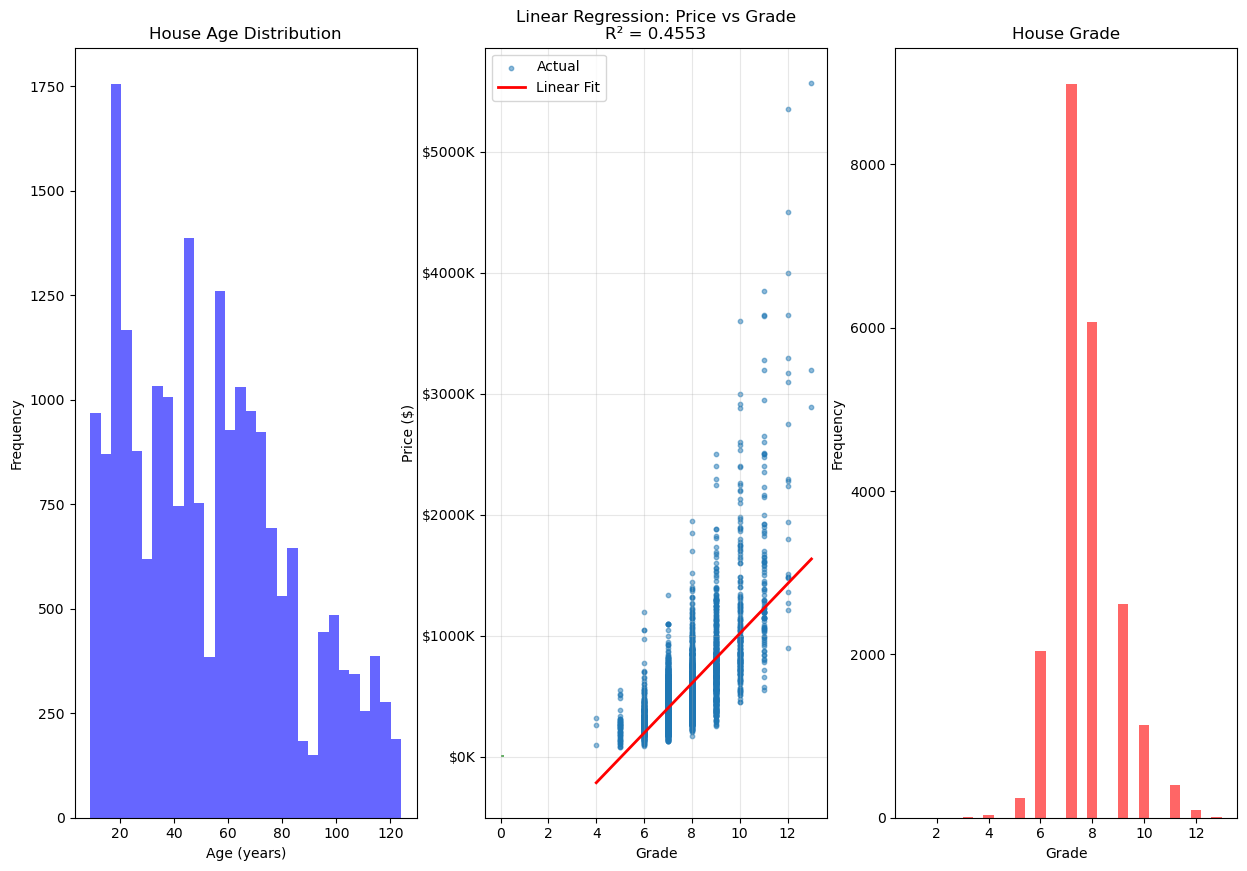

In [85]:
#Import House Sales Data

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime

myseries = pd.read_csv('/home/james/Documents/house_sales.csv')

print(myseries)

#Find Missing Data Values

missing_summary = myseries.isnull().sum()
print("Missing values per column:")
for col, count in missing_summary.items():
    if count > 0:
        print(f"{col}: {count} ({count/len(myseries)*100}%)")

#Missing Value Per Room Feature

myseries['bedrooms'] = myseries['bedrooms'].fillna(myseries['bedrooms'].median())
myseries['bathrooms'] = myseries['bathrooms'].fillna(myseries['bathrooms'].median())
myseries['sqft_living'] = myseries['sqft_living'].fillna(myseries['sqft_living'].median())
myseries['sqft_lot'] = myseries['sqft_lot'].fillna(myseries['sqft_lot'].median())

print(f"Missing values after cleaning: {myseries.isnull().sum().sum()}")

#Data Type Conversions

myseries['date'] = pd.to_datetime(myseries['date'], format='%Y%m%dT%H%M%S')


#Outliers For Time and Location Features

outlier_columns = ['year_built', 'year_renovated', 'grade', 'view', 'waterfront']

#House Age and condition

myseries['price_per_sqft'] = myseries['price'] / myseries['sqft_living']
myseries['house_age'] = 2024 - myseries['yr_built']
myseries['years_since_renovation'] = np.where(myseries['yr_renovated'] == 0, 
                                       myseries['house_age'], 
                                       2024 - myseries['yr_renovated'])

myseries['is_renovated'] = (myseries['yr_renovated'] > 0).astype(int)
myseries['basement_ratio'] = myseries['sqft_basement'] / myseries['sqft_living']


#Visualizations

plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

axes[0].hist(myseries['house_age'], bins=30, alpha=0.6, color='blue')
axes[0].set_title('House Age Distribution')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')

axes[1].hist(myseries['view'], bins=30, alpha=0.6, color='green')
axes[1].set_title('House View')
axes[1].set_xlabel('View Score')
axes[1].set_ylabel('Frequency')

axes[2].hist(myseries['grade'], bins=30, alpha=0.6, color='red')
axes[2].set_title('House Grade')
axes[2].set_xlabel('Grade')
axes[2].set_ylabel('Frequency')


#Initial Linear Regression Model

grade = myseries[['grade']].copy()
price = myseries['price'].copy()

# def train_grade_model(grade_values, price_values):
grade_train, grade_test, price_train, price_test = train_test_split(grade, price, test_size=0.2, random_state=42)


linear_model = LinearRegression()
linear_model.fit(grade_train, price_train)

price_train_pred_linear = linear_model.predict(grade_train)
price_test_pred_linear = linear_model.predict(grade_test)


# R2 Score, Squared Error, and Absolute Error Metrics

train_r2_linear = r2_score(price_train, price_train_pred_linear)
test_r2_linear = r2_score(price_test, price_test_pred_linear)
train_rmse_linear = np.sqrt(mean_squared_error(price_train, price_train_pred_linear))
test_rmse_linear = np.sqrt(mean_squared_error(price_test, price_test_pred_linear))
train_mae_linear = mean_absolute_error(price_train, price_train_pred_linear)
test_mae_linear = mean_absolute_error(price_test, price_test_pred_linear)

#Linear Regression Equation

slope = linear_model.coef_[0]
intercept = linear_model.intercept_
print(f"\nLinear Regression Equation:")
print(f"Price = {intercept:,.0f} + {slope:,.0f} × Grade")
print(f"For each grade increase, price increases by ${slope:,.0f}")


#Linear Regression Scatterplot

axes[1].scatter(grade_test, price_test, alpha=0.5, s=10, label='Actual')
axes[1].plot(grade_test.sort_values('grade'), 
                linear_model.predict(grade_test.sort_values('grade')), 
                'r-', linewidth=2, label='Linear Fit')
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Price ($)')
axes[1].set_title(f'Linear Regression: Price vs Grade\nR² = {test_r2_linear:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

